Download the necessary libraries & import data.

In [227]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA, NMF
from scipy.spatial.distance import pdist, squareform
from adjustText import adjust_text
from itertools import combinations

In [228]:
df = pd.read_csv('authors.csv').rename(columns = {'Unnamed: 0': 'Author'})
X = df.copy().drop(['Author','BookID'], axis=1)


### NMF on Features

Using NMF we are able to perform dimensionality reduction while finding interpretable patterns by grouping words that describe chapters by themes/topics.

In [229]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(X_transpose.shape[1])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


Now we run NMF and get two components, W and H.  
- W represents chapters x topics
- H represents topics x words

In [230]:
# Add a small constant to avoid zeros (NMF needs non-negative data)
X_nmf = X_transpose + 1e-6

# Run NMF with k topics
k = 4 # hyperparameter
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X_nmf)  # shape: (69 words, k topics)
H = model.components_           # shape: (k topics, 841 chapters)

In [231]:
# Turn W into a DataFrame with labels
W_df = pd.DataFrame(W, index=X_transpose.index, columns=[f'Topic{i+1}' for i in range(k)])
W_df 

,Topic1,Topic2,Topic3,Topic4
a,12.703487,9.567095,0.483944,2.602374
all,1.079770,1.396586,2.248865,1.258959
also,0.229118,0.000000,0.144176,0.000000
an,4.549360,1.441845,0.000000,0.054374
and,9.307504,5.728211,17.722282,6.001697
...,...,...,...,...
who,0.059405,0.297646,1.169796,0.495165
will,0.000000,3.631641,0.258497,0.254086
with,0.746218,2.372410,4.244667,2.023698
would,0.484461,1.523643,0.000000,1.441098


In [232]:
# Turn H into a Dataframe with labels
H_df = pd.DataFrame(H)
H_df.columns = X_transpose.columns
H_df.index = [f'Topic{i}' for i in range(1,k+1)]
H_df

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
Topic1,1.388966,1.406549,0.697125,1.341688,1.325401,0.606958,1.100097,1.038123,0.642489,1.109125,...,0.452674,0.064731,0.356161,0.000000,0.127045,0.000000,0.000000,0.000000,0.000000,0.004147
Topic2,0.009625,0.696674,1.926100,0.560298,1.205885,1.993447,1.558374,0.700953,1.326439,1.483529,...,2.290017,2.867645,2.365239,2.523490,2.126112,3.074310,2.331398,2.339809,2.365277,2.150821
Topic3,0.693948,0.407469,0.244815,1.406300,1.412570,0.901878,0.404283,1.671437,0.686905,0.534818,...,1.306350,0.814292,1.315700,1.414172,1.052886,0.415843,1.488557,1.559131,2.089887,2.400112
Topic4,5.035964,3.640911,2.708667,3.313697,2.078612,1.684179,2.091687,3.495083,3.473353,2.777374,...,0.431708,0.867872,0.000000,0.220475,1.281741,0.620481,1.091426,0.280570,0.236132,0.000000


Now lets interpret our topics.

In [233]:
top_words_per_topic = {}
top_n = 15
for topic in W_df.columns:
    top_words = W_df[topic].sort_values(ascending=False).head(top_n)
    top_words_per_topic[topic] = top_words.index.tolist()

summary_df = pd.DataFrame(top_words_per_topic)
summary_df #importance in ascending order!

,Topic1,Topic2,Topic3,Topic4
0,the,the,and,to
1,was,a,the,her
2,of,to,of,and
3,a,my,to,of
4,and,is,his,was
5,in.,of,in.,be
6,it,it,with,not
7,had,that,from,had
8,that,not,all,as
9,an,and,their,it


Topic 1 = Narritive/Descriptive (past tense)

Topic 2 = Reflective/Personal voice

Topic 3 = Relational

Topic 4 = Dialogue/Character-driven phrasing

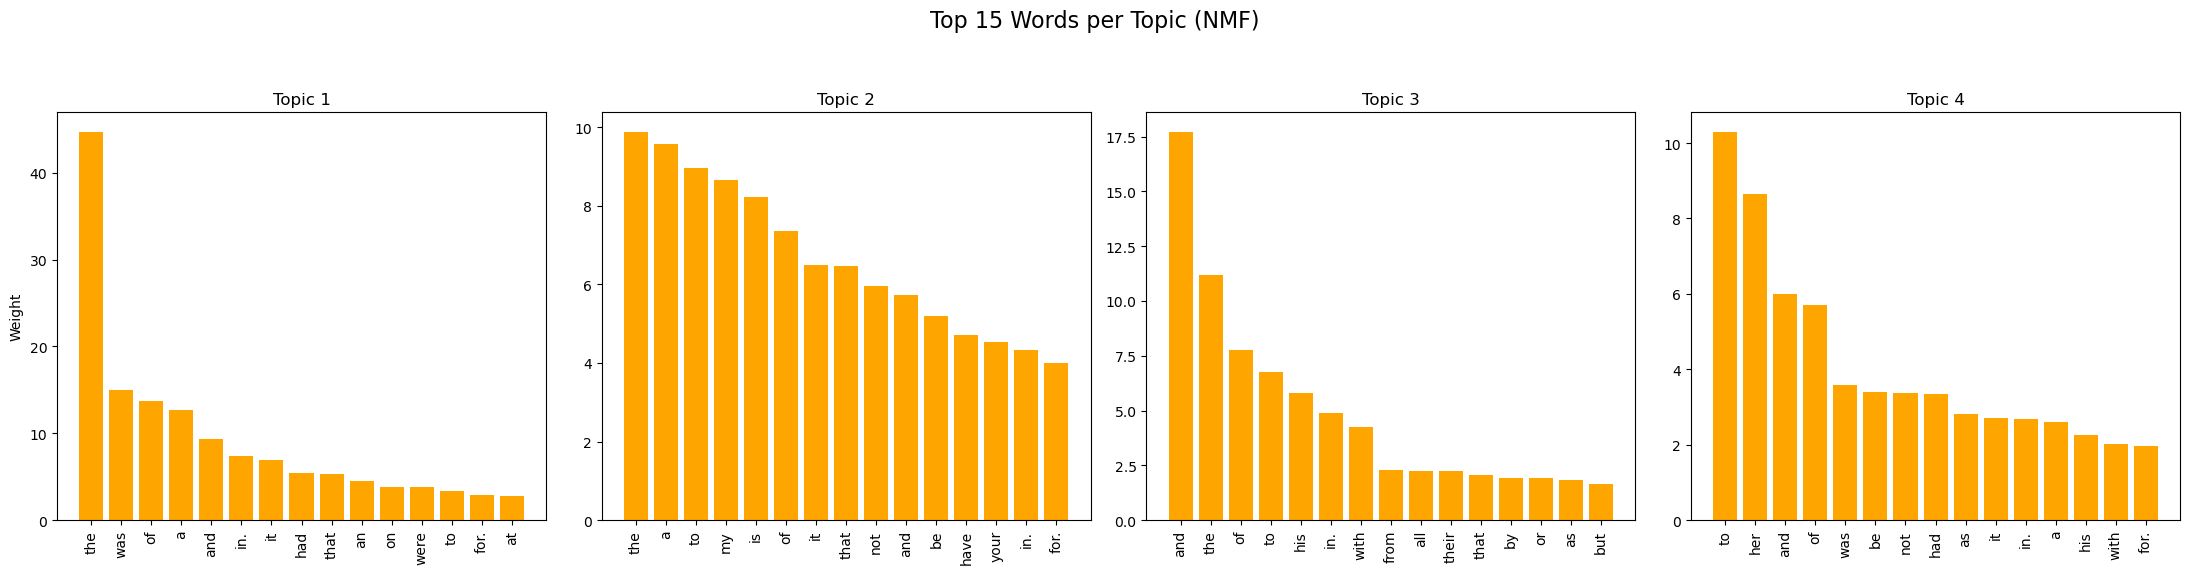

In [234]:
# visualize
topics = W_df.columns
fig, axes = plt.subplots(1, len(topics), figsize=(22, 6), sharey=False)

for i, topic in enumerate(topics):
    top_words = W_df[topic].sort_values(ascending=False).head(top_n)
    
    x = list(range(len(top_words)))
    axes[i].bar(x, top_words.values, color = 'orange')
    axes[i].set_title(f"Topic {i+1}")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(top_words.index, rotation=90)
    
    if i == 0:
        axes[i].set_ylabel("Weight")

plt.suptitle(f"Top {top_n} Words per Topic (NMF)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

plt.savefig(fname = 'NMF topics')
plt.show()

Now lets determine which chapters correspond to which topics!

In [235]:
chapter_topic_df = H_df.T  # shape: (chapters × topics)
chapter_topic_df["Author"] = df['Author'].values
chapter_topic_df

,Topic1,Topic2,Topic3,Topic4,Author
Chapter0,1.388966,0.009625,0.693948,5.035964,Austen
Chapter1,1.406549,0.696674,0.407469,3.640911,Austen
Chapter2,0.697125,1.926100,0.244815,2.708667,Austen
Chapter3,1.341688,0.560298,1.406300,3.313697,Austen
Chapter4,1.325401,1.205885,1.412570,2.078612,Austen
...,...,...,...,...,...
Chapter836,0.000000,3.074310,0.415843,0.620481,Shakespeare
Chapter837,0.000000,2.331398,1.488557,1.091426,Shakespeare
Chapter838,0.000000,2.339809,1.559131,0.280570,Shakespeare
Chapter839,0.000000,2.365277,2.089887,0.236132,Shakespeare


In [236]:
# which author uses which topic more

author_topic_means = chapter_topic_df.groupby("Author").mean()
index_ = list(author_topic_means.index)
author_topic_means = author_topic_means.reset_index(drop=True)
author_topic_means.index = index_
author_topic_means

,Topic1,Topic2,Topic3,Topic4
Austen,0.887521,1.142230,0.867567,3.598350
London,1.858757,0.697897,1.918367,1.121614
Milton,0.258264,0.617670,3.870995,1.008754
Shakespeare,0.260634,2.244848,1.907850,0.338706


From this we can see that Austen heavily uses topic4; London uses topics 1,2,3; Milton heavily uses topic 3; Shakespeare is split between topic 2 and 3; 

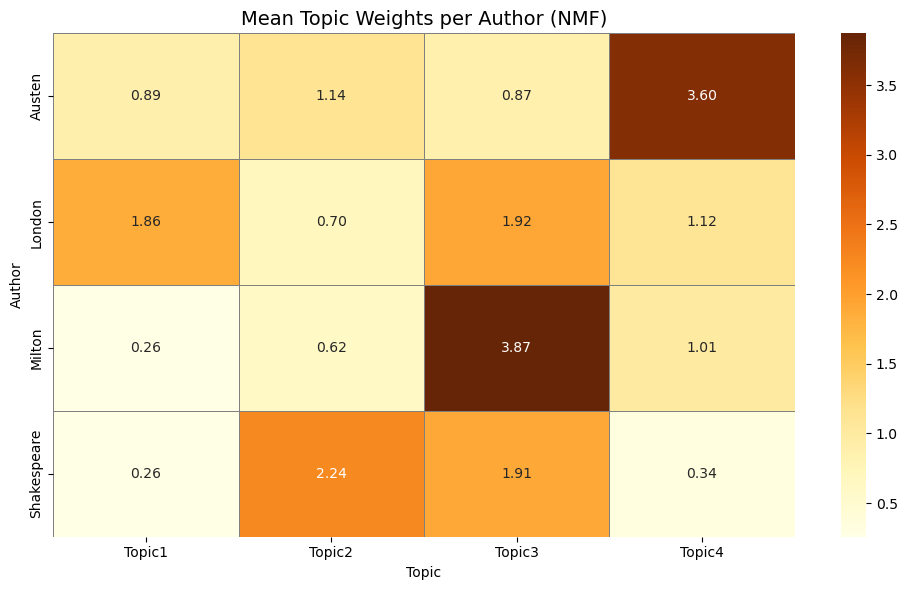

In [237]:
# Visualize these results

plt.figure(figsize=(10, 6))
sns.heatmap(author_topic_means, annot=True, fmt=".2f", cmap="YlOrBr",
            linewidths=0.5, linecolor='gray')

plt.title("Mean Topic Weights per Author (NMF)", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Author")
plt.tight_layout()

# plt.savefig("author_topic_heatmap.png", dpi=300)

plt.show()


## NMF on Observations

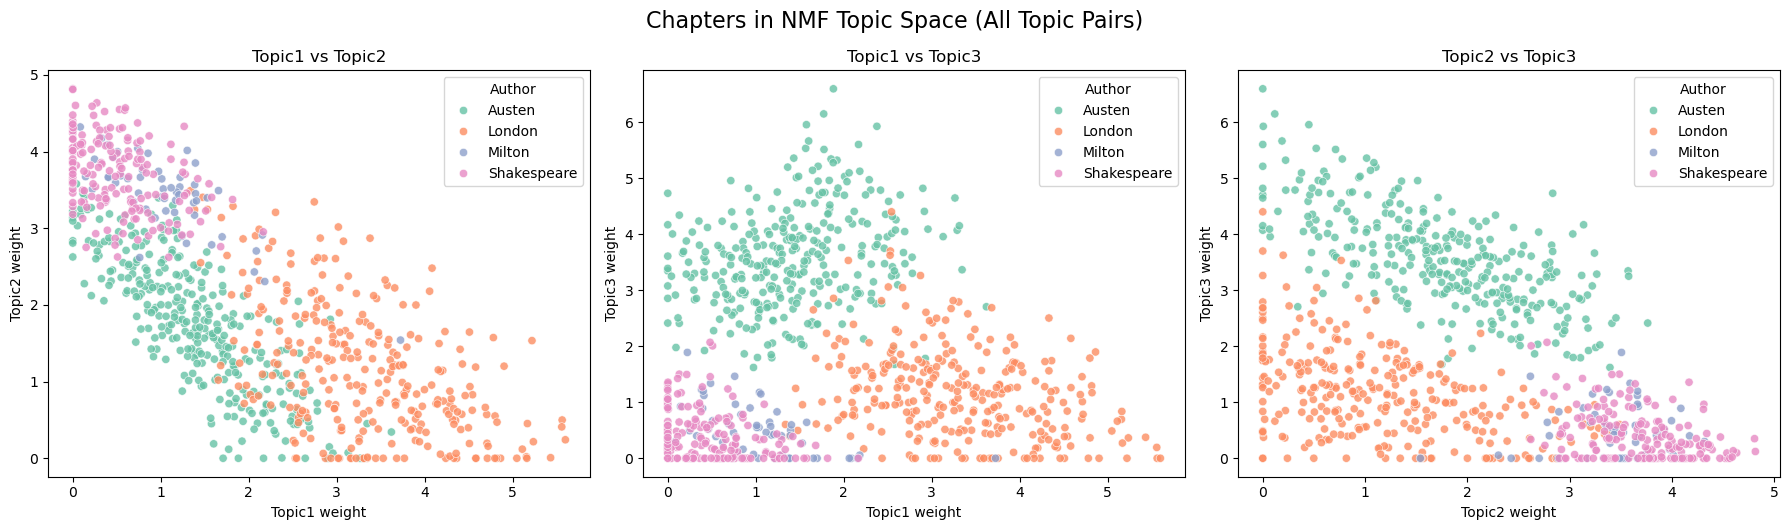

In [238]:
# Add a small constant to avoid zeros (NMF needs non-negative data)
X_nmf = X + 1e-6

# Run NMF with k topics
k = 3 # hyperparameter
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X_nmf)  # shape: (69 words, k topics)
H = model.components_           # shape: (k topics, 841 chapters)

# Turn W into a DataFrame with word labels
W_df = pd.DataFrame(W, index=X.index, columns=[f'Topic{i+1}' for i in range(k)])

# Prepare combined DataFrame
topic_df = W_df.reset_index(drop=True)
topic_df["Author"] = df["Author"].reset_index(drop=True)

# List of topic names
topics = W_df.columns.tolist()

# All pairs of topics
topic_pairs = list(combinations(topics, 2))

# Plot each pair
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for i, (x_topic, y_topic) in enumerate(topic_pairs):
    ax = axes[i]
    sns.scatterplot(
        data=topic_df,
        x=x_topic, y=y_topic,
        hue="Author",
        palette="Set2",
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"{x_topic} vs {y_topic}")
    ax.set_xlabel(f"{x_topic} weight")
    ax.set_ylabel(f"{y_topic} weight")
    ax.legend().set_title("Author")

plt.tight_layout()
plt.suptitle("Chapters in NMF Topic Space (All Topic Pairs)", fontsize=16, y=1.05)
plt.show()